In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [73]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [74]:
from silentspeak.loading import *
from silentspeak.params import local_data_path, instance_data_path, data_size, data_source, n_frames
from silentspeak.model import load_and_compile_model, checkpoint_callback, schedule_callback, predict_test
from silentspeak.main import train, mappable_function

In [75]:
if data_source == "local":
    data_path = local_data_path
else:
    data_path = instance_data_path
    pass

data_path

'/Users/ArthurPech/code/ssaulay/silentspeak/raw_data'

In [76]:
vocab_dict = [{"char" : char, "num" : char_to_num(char).numpy()} for char in vocab]
vocab_df = pd.DataFrame.from_dict(vocab_dict)
vocab_df

,char,num
0,a,1
1,deux,2
2,i,3
3,O,4
4,E,5
5,S,6
6,Z,7
7,N,8
8,o,9
9,u,10


# Load Model

In [77]:
model = load_and_compile_model()

###### Defining model ######
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 115, 54, 80, 64)   1792      
                                                                 
 activation_6 (Activation)   (None, 115, 54, 80, 64)   0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 115, 27, 40, 64)  0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 115, 27, 40, 128)  221312    
                                                                 
 activation_7 (Activation)   (None, 115, 27, 40, 128)  0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 115, 13, 20, 128)  0        
 3D)                     

In [78]:
model

# Load Data

In [79]:
# Params
epochs = 10
batch_size = 2
padded_frames_shape = [n_frames,None,None,None]
padded_transcripts_shape = [50]
train_size = 10
callbacks = [checkpoint_callback, schedule_callback]


In [80]:
# Load data
data = tf.data.Dataset.list_files(
    os.path.join(data_path, data_size, "videos", "*.avi")
    )
data = data.map(mappable_function)
data = data.padded_batch(
    batch_size,
    padded_shapes = (padded_frames_shape, padded_transcripts_shape))
data = data.prefetch(tf.data.AUTOTUNE)

In [81]:
# Train / Test
# NOT USED
train = data.take(train_size)
test = data.skip(train_size)

In [82]:
# SAMPLE FOR TEST
# ---> a batch of 2 couples of X (frames) and y (num transcripts)
# ---> val[0] = 2 videos
# ---> val[1] = 2 frames
sample = data.as_numpy_iterator()
val = sample.next()
type(val), len(val)

(tuple, 2)

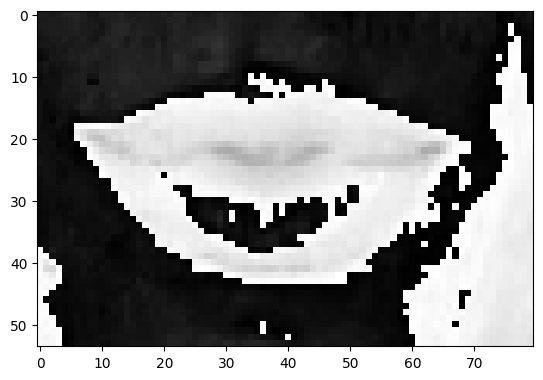

In [83]:
# 1st Video of the 2 videos in the sample batch
# Frame #10
plt.imshow(val[0][0][10], cmap = "gray")

In [84]:
val[1][0]

array([11, 29, 20, 12, 21, 12, 20, 13,  1, 27, 18, 30, 17, 31, 29,  3,  6,
        2, 27, 21, 14, 22,  3,  2, 20, 30,  3, 22, 30,  4, 31, 22, 12, 31,
       12, 11, 29, 32, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [85]:
# 1st transcript of the 2 transcripts in the batch
tf.strings.reduce_join(
    [num_to_char(word) for word in val[1][0]],
    separator = ".")

<tf.Tensor: shape=(), dtype=string, numpy=b'y.n.k.e.b.e.k.w.a.z.p.l.neuf.R.n.i.S.deux.z.b.a~.d.i.deux.k.l.i.d.l.O.R.d.e.R.e.y.n.j.o~...........'>

# Test model before train

In [86]:
val[0].shape, val[1].shape

((2, 115, 54, 80, 1), (2, 50))

In [87]:
# On ne prédit que les vidéos, sans les transcripts
# mais on prédit 2 vidéos d'un coup --> prédit 2 séquences de 115 probabilités à 35 possibilités
yhat = model.predict(val[0])
yhat.shape

1/1 [==============================] - 10s 10s/step


(2, 115, 35)

In [88]:
# Prediction = Probabilities d'obtenir chacun des 35 caractères
print(yhat[0].shape) # 115 sequences x 35 probabilities
print(yhat[0][1]) # The first set of 35 probabilities
np.argmax(yhat[0][1]), num_to_char(np.argmax(yhat[0][0]))

(115, 35)
[0.03989349 0.03600574 0.02392587 0.02346541 0.03400773 0.03185267
 0.02381143 0.02374934 0.03890927 0.03601625 0.01675161 0.03694653
 0.03495716 0.02429385 0.02073014 0.0316539  0.03597581 0.02363571
 0.02110918 0.02735558 0.03277517 0.0250142  0.02991413 0.0356871
 0.0241957  0.02941576 0.03050995 0.02682928 0.03622901 0.02760277
 0.02453719 0.02384797 0.01984908 0.02007321 0.02847272]


(0, <tf.Tensor: shape=(), dtype=string, numpy=b''>)

In [89]:
# Decode the prediction
tf.strings.reduce_join(
    [num_to_char(tf.argmax(x)) for x in yhat[0]],
    separator = "."
    )

<tf.Tensor: shape=(), dtype=string, numpy=b'..N.N.N.N.N.N.N.N.N.N.N.N.N.N.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.o.......o.o.o.o.o.o.o.o.o....N.a.a.a.a.a.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N.N'>

In [90]:
decoded = tf.keras.backend.ctc_decode(
    tf.expand_dims(yhat[0], axis = 0),
    input_length=[n_frames],
    greedy=True)
#[0][0].numpy()

decoded

([<tf.Tensor: shape=(1, 115), dtype=int64, numpy=
  array([[ 0,  8,  9,  0,  9,  0,  8,  1,  8, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1]])>],
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[367.03687]], dtype=float32)>)

# Train the model

In [91]:
# Environ 3'30 par époque sur mon pc

In [92]:
model.fit(
        data,
        epochs = 50,
        callbacks = callbacks
        )

Epoch 1/50
6/6 [==============================] - 211s 31s/step - loss: 280.2718 - lr: 1.0000e-04
Epoch 2/50
6/6 [==============================] - 145s 23s/step - loss: 226.7440 - lr: 1.0000e-04
Epoch 3/50
6/6 [==============================] - 145s 23s/step - loss: 204.7615 - lr: 1.0000e-04
Epoch 4/50
6/6 [==============================] - 201s 34s/step - loss: 181.7104 - lr: 1.0000e-04
Epoch 5/50
6/6 [==============================] - 220s 36s/step - loss: 148.0317 - lr: 1.0000e-04
Epoch 6/50
6/6 [==============================] - 145s 24s/step - loss: 119.6495 - lr: 1.0000e-04
Epoch 7/50
6/6 [==============================] - 145s 23s/step - loss: 112.4206 - lr: 1.0000e-04
Epoch 8/50
6/6 [==============================] - 145s 23s/step - loss: 107.4943 - lr: 1.0000e-04
Epoch 9/50
6/6 [==============================] - 147s 24s/step - loss: 104.4442 - lr: 1.0000e-04
Epoch 10/50
6/6 [==============================] - 1194s 27s/step - loss: 103.9870 - lr: 1.0000e-04
Epoch 11/50
6/6 [=

In [101]:
models_path = os.path.join(data_path, "..", "models")
model.save(os.path.join(models_path, "model_50.h5"))

# Predict after train

In [93]:
# Predict 2 videos
yhat_after = model.predict(val[0])

1/1 [==============================] - 7s 7s/step


In [94]:
# Predict 2 transcripts
yhat_after.shape

(2, 115, 35)

In [95]:
# 1st prediction
yhat_after[0]

array([[6.6689248e-03, 4.9116418e-02, 6.0671709e-02, ..., 2.3884919e-02,
        4.7447234e-03, 3.5515696e-02],
       [8.7665701e-03, 5.3816408e-02, 5.7486117e-02, ..., 2.4384188e-02,
        4.0612556e-03, 4.7229569e-02],
       [1.0817815e-02, 5.5060580e-02, 5.6182325e-02, ..., 2.4669716e-02,
        3.5782706e-03, 5.9087008e-02],
       ...,
       [4.8339477e-01, 1.8094832e-04, 2.3973861e-04, ..., 3.3588213e-04,
        4.7793805e-05, 5.0944895e-01],
       [4.7015193e-01, 4.0837319e-04, 6.8676559e-04, ..., 9.2483405e-04,
        1.4165993e-04, 5.1188880e-01],
       [4.4255182e-01, 1.0556794e-03, 2.1840415e-03, ..., 2.9845508e-03,
        5.3026906e-04, 5.0451839e-01]], dtype=float32)

In [96]:
np.argmax(yhat_after[0][1]), num_to_char(np.argmax(yhat_after[0][0]))

(29, <tf.Tensor: shape=(), dtype=string, numpy=b'n'>)

In [97]:
# Decode the 1st prediction
tf.strings.reduce_join(
    [num_to_char(tf.argmax(x)) for x in yhat_after[0]],
    separator = "."
    )

<tf.Tensor: shape=(), dtype=string, numpy=b'n.n.n.i...............................................................................................................'>

In [98]:
yhat_after[0].shape

(115, 35)

In [99]:
decoded_after = tf.keras.backend.ctc_decode(
    tf.expand_dims(yhat_after[0], axis = 0),
    input_length=[n_frames],
    greedy=True)
#[0][0].numpy()

decoded_after

([<tf.Tensor: shape=(1, 115), dtype=int64, numpy=
  array([[29,  3,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1]])>],
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[86.00624]], dtype=float32)>)

In [103]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded_after]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'ni'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b''>]

# Test sur le vocab size

In [100]:
for i in range(35):
    print(i, [num_to_char(i).numpy().decode()])

0 ['']
1 ['a']
2 ['deux']
3 ['i']
4 ['O']
5 ['E']
6 ['S']
7 ['Z']
8 ['N']
9 ['o']
10 ['u']
11 ['y']
12 ['e']
13 ['w']
14 ['a~']
15 ['U~']
16 ['o~']
17 ['neuf']
18 ['p']
19 ['t']
20 ['k']
21 ['b']
22 ['d']
23 ['g']
24 ['f']
25 ['s']
26 ['v']
27 ['z']
28 ['m']
29 ['n']
30 ['l']
31 ['R']
32 ['j']
33 ['H']
34 ['']
